# INF265 - Weeks 14-15: LSTM-based character level language models
Jakub Ryšavý

## Introduction

### Overview
In this assignment, we aim to design a simple character level language model in order to be able to generate new text similar to the text trained on during the
learning stage. More specifically and as implied by the name, character level language models operate at the level of characters (as opposed to words): given a fixed length sequence of characters, these models are trained to guess what
could be the next character. Owing to the sequential nature of the task, these models pair well with the so-called recurrent neural networks, a class of neural networks able to process sequential input by updating their internal state. Of particular interest are LSTMs (acronym for long short-term memory), a category of recurrent neural networks designed around the notion of ”gates” in order to better control the gradient flow and to mitigate the vanishing of the gradient
problem. In that sense, the connection between LSTMs and recurrent neural networks is comparable to that between residual networks and traditional feed-forward networks.

**In a nutshell, the main goal of this assignment will be for you to learn how to set up a whole pipeline with limited guidance in order to solve a natural language processing task.**

### Useful resources
- Stanford lecture on RNNs: https://youtu.be/6niqTuYFZLQ
- Project Gutemberg: https://www.gutenberg.org/

## Exercise


In [16]:
import numpy as np
import pandas as pd

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from tqdm.notebook import tqdm, trange
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from collections import Counter


### 1. Download a text document that you like.
The project Gutemberg is a good place to obtain legally interesting books!

In [17]:
# !wget https://www.gutenberg.org/files/64317/64317-0.txt -O Great_Gatsby.txt
!wget https://www.gutenberg.org/files/1342/1342-0.txt -O PrideAndPrejudice.txt
!ls

--2021-05-02 05:51:25--  https://www.gutenberg.org/files/1342/1342-0.txt
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 799645 (781K) [text/plain]
Saving to: ‘PrideAndPrejudice.txt’

PrideAndPrejudice.t 100%[===================>] 780.90K  1.39MB/s    in 0.6s    

2021-05-02 05:51:26 (1.39 MB/s) - ‘PrideAndPrejudice.txt’ saved [799645/799645]

PrideAndPrejudice.txt  __notebook_source__.ipynb  best.pth


### 2. Load and clean up the text.
You will 
- remove all accents, 
- force all letters to be lower case, 
- remove all occurrences of ”\n”, ”\t” and ”\r” 
- and make sure every two consecutive words in the text are separated by a single space ” ”. 
- You can also remove part (or all) of the punctuation.

In [18]:
import re
import unicodedata

def remove_accents(input_str):
    '''Source: https://stackoverflow.com/a/517974'''
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return u"".join([c for c in nfkd_form if not unicodedata.combining(c)])

In [19]:
def preprocess(text, verbose=True):
    l = len(text)
    # remove accents
    text = remove_accents(text)

    # lower case
    text = text.lower()

    # remove ”\n”, ”\t” and ”\r” 
    text = re.sub(r"[\ufeff\n\t\s]+", ' ', text)

    # verify word separation by single space
    # text = re.sub(r"[\s]+", ' ', text)
    text = ' '.join(text.split()) + ' '

    # remove punctuation
    text = re.sub(r"[;:,]+", '', text) # TODO: try to remove ','

    # MY APPROACH
    # remove numbers
    text = re.sub(r"[0123456789]+", '', text)

    # replace short forms (contractions) with full form
    text = re.sub(r"it’s", "it is", text)
    text = re.sub(r"i’ll", "i will", text)
    text = re.sub(r"i’m", "i am", text)
    text = re.sub(r"i’v", "i have", text)
    text = re.sub(r"i’d", "i had", text) # this is not correct for all the cases, but this is more offten
    text = re.sub(r"we’ve", "we have", text)
    text = re.sub(r"we’re", "we are", text)

    # remove special characters 
    text = re.sub(r"[#\[\](){}}\*&@$€%—\-\\/'\"““”«»„“»«‘’`’_]+", '', text)

    if verbose:
        removed = l-len(text)
        if removed != 0:
            print(f"{removed} characters was removed during preprocessing.")
    return text

###################################################

book = ""
# filename = 'Great_Gatsby.txt'
filename = 'PrideAndPrejudice.txt'
num_lines = sum(1 for line in open(filename,'r'))
# print(f"\nThe book {filename[:-4]} has {num_lines} lines.")

with open(filename) as f:
    for line in tqdm(f, total=num_lines):
    # for line, i in zip(f, range(500)):
        if len(line) <= 1:
            continue
        book = book + preprocess(line, verbose=False)
        # print(line, end='')

print("###################")
book[10000:11000]

  0%|          | 0/14580 [00:00<?, ?it/s]

###################


' husband any satisfactory description of mr. bingley. they attacked him in various wayswith barefaced questions ingenious suppositions and distant surmises but he eluded the skill of them all and they were at last obliged to accept the secondhand intelligence of their neighbour lady lucas. her report was highly favourable. sir william had been delighted with him. he was quite young wonderfully handsome extremely agreeable and to crown the whole he meant to be at the next assembly with a large party. nothing could be more delightful! to be fond of dancing was a certain step towards falling in love and very lively hopes of mr. bingleys heart were entertained. if i can but see one of my daughters happily settled at netherfield said mrs. bennet to her husband and all the others equally well married i shall have nothing to wish for. in a few days mr. bingley returned mr. bennets visit and sat about ten minutes with him in his library. he had entertained hopes of being admitted to a sight o

In [20]:
# book = "test!"

### 3. Create a character-based vocabulary from the preprocessed text: 
Every appearing character will have a unique integer ID. You can use a dictionary structure to store the vocabulary.

In [21]:
vocabulary = {}
alphabet = set(book)
vocabulary = dict((i, c) for i, c in enumerate(sorted(alphabet)))
vocabulary_rev = dict((c, i) for i, c in vocabulary.items())
vocab_size = len(vocabulary)
print(vocab_size)
print(vocabulary.items())
print(vocabulary_rev.items())

30
dict_items([(0, ' '), (1, '!'), (2, '.'), (3, '?'), (4, 'a'), (5, 'b'), (6, 'c'), (7, 'd'), (8, 'e'), (9, 'f'), (10, 'g'), (11, 'h'), (12, 'i'), (13, 'j'), (14, 'k'), (15, 'l'), (16, 'm'), (17, 'n'), (18, 'o'), (19, 'p'), (20, 'q'), (21, 'r'), (22, 's'), (23, 't'), (24, 'u'), (25, 'v'), (26, 'w'), (27, 'x'), (28, 'y'), (29, 'z')])
dict_items([(' ', 0), ('!', 1), ('.', 2), ('?', 3), ('a', 4), ('b', 5), ('c', 6), ('d', 7), ('e', 8), ('f', 9), ('g', 10), ('h', 11), ('i', 12), ('j', 13), ('k', 14), ('l', 15), ('m', 16), ('n', 17), ('o', 18), ('p', 19), ('q', 20), ('r', 21), ('s', 22), ('t', 23), ('u', 24), ('v', 25), ('w', 26), ('x', 27), ('y', 28), ('z', 29)])


### 4. Generate the data $(X, y)$ for a character level language model:
a) Decide of a sequence length $L$.

b) For every sub-sequence formed from $L + 1$ consecutive characters in
your text (with stride 1):

- i. Convert every character from that sub-sequence into its corresponding integer ID.

- ii. Convert the $L$ first integer IDs into one-hot vectors (whose size will be equal to the size of the vocabulary) and store them in the
features matrix $X$.

- iii. Store the last integer ID in the labels vector $y$ (remember that in pytorch, labels do not need to be one-hot encoded).



Assuming $N$ is the number of such sub-sequences and $S$ is the size of the vocabulary, the above procedure should yield two tensors $X$ and
y of respective shape $(N, L, S)$ and $(N, )$.

Let us illustrate this with a toy example. We consider the following text: ”test!”. The vocabulary is {0: ”!”, 1: ”e”, 2: ”s”, 3: ”t”} thus $S = 4$. We choose to fix the sequence length to $L = 3$, which results in $N = 2$ sub-sequences [”t”, ”e”, ”s”, ”t”] and [”e”, ”s”, ”t”, ”!”]. The data would therefore be $(X, y)$ as returned by the following procedure:

[image]

**Hint:** Extracting the sub-sequences can be done efficiently using the `torch.nn.functional.unfold()` method. The one-hot encoding can be vectorized as well, using the `torch.scatter()` method in order to fill a zeros tensor.

I implemented this two times, because I missed the hint first.

In [22]:
L = 20

# Old uneffective implementation
def one_hot_encode(l):
    encoded = []
    for i, number in enumerate(l):
        zeros = [0]*vocab_size
        zeros[number] = 1
        encoded.append(zeros)
    return encoded

def extract_and_encode_OLD(L=L, book=book):
    X = []
    y = []
    for i in range(len(book)- (L)):
        subseq = book[i:i+L+1]
        '''Source: https://stackoverflow.com/a/13149770'''
        indexes = [list(vocabulary.keys())[list(vocabulary.values()).index(c)] for c in subseq]
        x = one_hot_encode(indexes[:-1])
        y.append(indexes[-1])
        X.append(x)

    X = torch.Tensor(X)
    y = torch.Tensor(y).type(torch.LongTensor)
    dataset = TensorDataset(X, y)
    print(f"X.size = {X.size()}, y.size={y.size()}")
    return dataset
# extract_and_encode_OLD()

In [23]:
def extract_and_encode(L=L, book=book, verbose=False):
    indexes = torch.LongTensor([vocabulary_rev[char] for char in book])
    unfolded = indexes.unfold(0, L+1, 1)
    y = unfolded[:, -1] #.long()
    X = torch.nn.functional.one_hot(unfolded[:, :-1], num_classes=vocab_size).float()
    if verbose:
        print(f"X.size = {X.size()}, y.size={y.size()}")
    dataset = TensorDataset(X, y)
    return dataset

dataset = extract_and_encode(verbose=True)
dataset

X.size = torch.Size([684480, 20, 30]), y.size=torch.Size([684480])


### 5. Shuffle then split the data between train and validation sets.
You probably want to keep most of the data available for training.

In [24]:
def shuffle_and_split(dataset=dataset, batch_size=4096):
    train_len = int(0.8 * dataset.__len__())
    val_len = dataset.__len__() - train_len
    train_ds, val_ds = torch.utils.data.random_split(dataset, [train_len, val_len])

    train_dl = DataLoader(train_ds, shuffle=True, batch_size=batch_size)
    val_dl = DataLoader(val_ds, shuffle=True, batch_size=batch_size)
    return train_dl, val_dl

train_dl, val_dl = shuffle_and_split()

### 6. Implement a LSTM classifier designed to predict the next character from a sequence of $L$ consecutive characters.
A good starting point would be to stack a `torch.nn.LSTM()` module followed by a `torch.nn.Linear()` layer.

**Hint:** For this task, we need a ”many-to-one” type of LSTM.

In [25]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim=vocab_size, hidden_dim=32, layer_dim=2, output_dim=vocab_size):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        out, (hn, cn) = self.rnn(x)
        out = self.fc(out[:, -1, :])
        out = self.softmax(out)
        return out

LSTMClassifier()

LSTMClassifier(
  (rnn): LSTM(30, 32, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=32, out_features=30, bias=True)
  (softmax): Softmax(dim=1)
)

### 7. Implement the training loop.
You will choose carefully the loss function and a metric that are suitable for the task. Your code will print the loss and the chosen metric at the end of every epoch, both for the train and
the validation sets.

In [26]:
y = [y for (_,y) in dataset]
number_of_classes = Counter([int(yy) for yy in y])
print(number_of_classes.most_common())

[(0, 124742), (8, 71363), (23, 48271), (4, 42765), (18, 41410), (12, 38885), (17, 38735), (11, 34661), (22, 33875), (21, 33554), (7, 22850), (15, 22070), (24, 15512), (16, 15120), (6, 14133), (28, 13048), (26, 12600), (9, 12384), (10, 10448), (5, 9360), (19, 8730), (2, 6402), (25, 5840), (14, 3348), (13, 968), (29, 938), (27, 868), (20, 639), (1, 499), (3, 462)]


As we can see in the plot below, the classes (numbers of character occurences) are very **inbalanced**.
I decided to calculate _weight_ of the classes and use it for the _loss_ calculation.

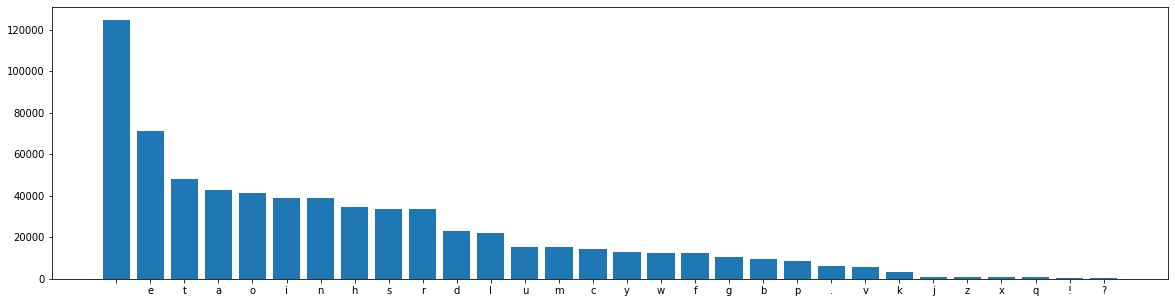

In [27]:
plt.figure(figsize=(20, 5))
plt.bar(x=[vocabulary[k] for (k,_) in number_of_classes.most_common()],
        height=[v for (_,v) in number_of_classes.most_common()])
plt.show()

In [28]:
# I tried to improve learning by using class weights, but it does not really help so it wasn't used at the end.

class_sample_count = np.unique(y, return_counts=True)[1]
weight = 1. / class_sample_count
# weight = class_sample_count / sum(class_sample_count) # my test - does not improve

weight = torch.from_numpy(weight).float()
weight

tensor([8.0165e-06, 2.0040e-03, 1.5620e-04, 2.1645e-03, 2.3384e-05, 1.0684e-04,
        7.0756e-05, 4.3764e-05, 1.4013e-05, 8.0749e-05, 9.5712e-05, 2.8851e-05,
        2.5717e-05, 1.0331e-03, 2.9869e-04, 4.5310e-05, 6.6138e-05, 2.5816e-05,
        2.4149e-05, 1.1455e-04, 1.5649e-03, 2.9803e-05, 2.9520e-05, 2.0716e-05,
        6.4466e-05, 1.7123e-04, 7.9365e-05, 1.1521e-03, 7.6640e-05, 1.0661e-03])

In [29]:
!pip install torchmetrics
from torchmetrics import Accuracy, Precision, MetricCollection

In [35]:
n_epochs = 420

model = LSTMClassifier()
model = LSTMClassifier(hidden_dim=32, layer_dim=2)
# iterations_per_epoch = len(train_dl)
# sched = CyclicLR(opt, cosine(t_max=iterations_per_epoch * 2, eta_min=lr/100))

def train_model(n_epochs=n_epochs, model=model, train_dl=train_dl, val_dl=val_dl, wd=0):
    best_acc = 0
    best_prec = 0
    best_epoch = 0
    patience, trials = 42, 0
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print("Actual device:", device)
    criterion = torch.nn.NLLLoss()
#     criterion = torch.nn.NLLLoss(weight=weight.to(device))
    # opt = torch.optim.RMSprop(model.parameters())#, lr=lr)
    opt = torch.optim.Adam(model.parameters(), weight_decay=wd) #, lr=lr)
    model.to(device)    

    print('Start model training')

    for epoch in trange(1, n_epochs + 1):
        metrics = MetricCollection([
            Accuracy(),
            Precision(num_classes=vocab_size, average='macro'),
            # Precision(),
            ]).to(device)
        metrics.reset()
        val_metrics = MetricCollection([
            Accuracy(),
            Precision(num_classes=vocab_size, average='macro'),
            # Precision(),
            ]).to(device)
        val_metrics.reset()
        for i, (x_batch, y_batch) in enumerate(train_dl):
            model.train()
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            # sched.step()
            opt.zero_grad()
            out = model(x_batch)
            loss = criterion(torch.log(out), y_batch)
            loss.backward()
            opt.step()

            preds = out.argmax(dim=1)
            # calculate train metrics
            metrics.update(preds, y_batch)
        
        model.eval()
        for x_val, y_val in val_dl:
            x_val, y_val = [t.to(device) for t in (x_val, y_val)]
            out = model(x_val)
            preds = out.argmax(dim=1)
            val_loss = criterion(torch.log(out), y_val)
            val_metrics.update(preds, y_val)

        res = metrics.compute()
        val_res = val_metrics.compute()
        print(f'''Epoch: {epoch:3d}. 
    TrainLoss: {loss.item():.4f}, TrainAcc.: {res["Accuracy"]:2.2%}, TrainPrecission {res["Precision"]:2.2%}
    ValidLoss: {val_loss.item():.4f}, ValidAcc.: {val_res["Accuracy"]:2.2%}, ValidPrecission {val_res["Precision"]:2.2%}''')
            # print(res)

        if val_res["Accuracy"].item() > best_acc:
            trials = 0
            best_acc = val_res["Accuracy"].item()
            best_prec = val_res["Precision"].item()
            best_epoch = epoch
            torch.save(model.state_dict(), 'best.pth')
            print(f'Epoch {epoch} best model saved with accuracy: {best_acc:2.2%}')
        else:
            trials += 1
            if trials >= patience:
                print(f'Early stopping on epoch {epoch}')
                break
    return best_epoch, best_acc, best_prec

train_model(n_epochs=1)
# train_model()

Actual device: cuda:0
Start model training


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:   1. 
    TrainLoss: 2.8828, TrainAcc.: 16.28%, TrainPrecission 1.04%
    ValidLoss: 2.8726, ValidAcc.: 18.26%, ValidPrecission 0.61%
Epoch 1 best model saved with accuracy: 18.26%


(1, 0.18262037634849548, 0.006087346002459526)

### 8. Finetune your model 
(for simplicity, no model selection pipeline required in this exercise): you will play with the hyperparameters of your model,
including (non-exclusively) the sequence length, the hidden size of the LSTM module, the number of layers in the LSTM module, the batch size and the weight decay.

In [31]:
n_layers = [1, 2, 3]
Ls = [5, 15, 20]
hidden_sizes = [16, 32, 64] # higher for overfitt
# batch_size = [4096] # I think, it does not involve training. But I realized that it influence the speed
weight_decays = [0.1, 0.05, 0.01, 0.001]

I am sorry for long outputs of the following cells. You can skip them and look at the section below [Results of finetuning](#results_finetuning). However, at the end of each long output, there is a table and short commentar.

#### Optimization of $layer\_dim$

In [32]:
n_epochs = 100
hidden_size = 32
results = pd.DataFrame(columns=["Parameters", "Best epoch", "Accuracy", "Precision"])
for n in tqdm(n_layers):
    print(n)
    model = LSTMClassifier(hidden_dim=hidden_size, layer_dim=n)
    res = train_model(n_epochs=n_epochs, model=model)
    results = results.append(
        pd.Series(
            [f"layer_dim={n}", *res],
            index=["Parameters", "Best epoch", "Accuracy", "Precision"]
        ), ignore_index=True
    )
results

  0%|          | 0/3 [00:00<?, ?it/s]

1
Actual device: cuda:0
Start model training


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch:   1. 
    TrainLoss: 2.8504, TrainAcc.: 16.58%, TrainPrecission 1.40%
    ValidLoss: 2.8360, ValidAcc.: 18.26%, ValidPrecission 0.61%
Epoch 1 best model saved with accuracy: 18.26%
Epoch:   2. 
    TrainLoss: 2.6517, TrainAcc.: 19.28%, TrainPrecission 5.95%
    ValidLoss: 2.6237, ValidAcc.: 22.03%, ValidPrecission 5.40%
Epoch 2 best model saved with accuracy: 22.03%
Epoch:   3. 
    TrainLoss: 2.4485, TrainAcc.: 27.56%, TrainPrecission 6.82%
    ValidLoss: 2.4425, ValidAcc.: 29.61%, ValidPrecission 7.14%
Epoch 3 best model saved with accuracy: 29.61%
Epoch:   4. 
    TrainLoss: 2.3146, TrainAcc.: 30.79%, TrainPrecission 11.50%
    ValidLoss: 2.3207, ValidAcc.: 31.67%, ValidPrecission 11.77%
Epoch 4 best model saved with accuracy: 31.67%
Epoch:   5. 
    TrainLoss: 2.2287, TrainAcc.: 33.21%, TrainPrecission 13.35%
    ValidLoss: 2.2079, ValidAcc.: 34.49%, ValidPrecission 13.85%
Epoch 5 best model saved with accuracy: 34.49%
Epoch:   6. 
    TrainLoss: 2.1857, TrainAcc.: 35.44%, T

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch:   1. 
    TrainLoss: 2.8393, TrainAcc.: 16.25%, TrainPrecission 1.24%
    ValidLoss: 2.8851, ValidAcc.: 18.26%, ValidPrecission 0.61%
Epoch 1 best model saved with accuracy: 18.26%
Epoch:   2. 
    TrainLoss: 2.6841, TrainAcc.: 20.45%, TrainPrecission 1.30%
    ValidLoss: 2.6964, ValidAcc.: 22.85%, ValidPrecission 1.41%
Epoch 2 best model saved with accuracy: 22.85%
Epoch:   3. 
    TrainLoss: 2.5223, TrainAcc.: 24.65%, TrainPrecission 4.83%
    ValidLoss: 2.5104, ValidAcc.: 27.98%, ValidPrecission 4.90%
Epoch 3 best model saved with accuracy: 27.98%
Epoch:   4. 
    TrainLoss: 2.4290, TrainAcc.: 28.38%, TrainPrecission 6.12%
    ValidLoss: 2.3515, ValidAcc.: 29.32%, ValidPrecission 5.37%
Epoch 4 best model saved with accuracy: 29.32%
Epoch:   5. 
    TrainLoss: 2.3380, TrainAcc.: 30.24%, TrainPrecission 7.67%
    ValidLoss: 2.3287, ValidAcc.: 32.06%, ValidPrecission 8.04%
Epoch 5 best model saved with accuracy: 32.06%
Epoch:   6. 
    TrainLoss: 2.2701, TrainAcc.: 32.19%, Train

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch:   1. 
    TrainLoss: 2.8649, TrainAcc.: 16.09%, TrainPrecission 0.95%
    ValidLoss: 2.8747, ValidAcc.: 18.26%, ValidPrecission 0.61%
Epoch 1 best model saved with accuracy: 18.26%
Epoch:   2. 
    TrainLoss: 2.8658, TrainAcc.: 18.21%, TrainPrecission 0.61%
    ValidLoss: 2.8615, ValidAcc.: 18.26%, ValidPrecission 0.61%
Epoch:   3. 
    TrainLoss: 2.8868, TrainAcc.: 18.21%, TrainPrecission 0.61%
    ValidLoss: 2.8818, ValidAcc.: 18.26%, ValidPrecission 0.61%
Epoch:   4. 
    TrainLoss: 2.7544, TrainAcc.: 18.38%, TrainPrecission 1.87%
    ValidLoss: 2.7542, ValidAcc.: 22.09%, ValidPrecission 2.26%
Epoch 4 best model saved with accuracy: 22.09%
Epoch:   5. 
    TrainLoss: 2.6370, TrainAcc.: 23.03%, TrainPrecission 6.62%
    ValidLoss: 2.6119, ValidAcc.: 24.92%, ValidPrecission 4.12%
Epoch 5 best model saved with accuracy: 24.92%
Epoch:   6. 
    TrainLoss: 2.5733, TrainAcc.: 25.35%, TrainPrecission 6.34%
    ValidLoss: 2.5118, ValidAcc.: 26.68%, ValidPrecission 6.08%
Epoch 6 best 

,Parameters,Best epoch,Accuracy,Precision
0,layer_dim=1,100,0.537357,0.504784
1,layer_dim=2,100,0.554224,0.534182
2,layer_dim=3,100,0.546035,0.482089


I realized, that **one** layer of LSTM is sufficient. Using more layers slightly increase the performance; however, training is much slower. Finally, I chosen $layer\_dim = 2$ because I wanted to use _dropout_ which is possible only for two or more layers (as it is not used in the last LSTM layer).

#### Optimization of $hidden\_size$

In [41]:
n_epochs = 100
n = 2
results_hs = pd.DataFrame(columns=["Parameters", "Best epoch", "Accuracy", "Precision"])
for hidden_size in tqdm(hidden_sizes):
    print(hidden_size)
    model = LSTMClassifier(hidden_dim=hidden_size, layer_dim=n)
    res = train_model(n_epochs=n_epochs, model=model)
    results_hs = results_hs.append(
        pd.Series(
            [f"hidden_size={hidden_size}", *res],
            index=["Parameters", "Best epoch", "Accuracy", "Precision"]
        ), ignore_index=True
    )
results_hs

  0%|          | 0/3 [00:00<?, ?it/s]

16
Actual device: cuda:0
Start model training


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch:   1. 
    TrainLoss: 2.8859, TrainAcc.: 14.52%, TrainPrecission 1.15%
    ValidLoss: 2.8564, ValidAcc.: 18.26%, ValidPrecission 0.61%
Epoch 1 best model saved with accuracy: 18.26%
Epoch:   2. 
    TrainLoss: 2.8638, TrainAcc.: 18.21%, TrainPrecission 0.61%
    ValidLoss: 2.8992, ValidAcc.: 18.26%, ValidPrecission 0.61%
Epoch:   3. 
    TrainLoss: 2.8491, TrainAcc.: 18.21%, TrainPrecission 0.61%
    ValidLoss: 2.8463, ValidAcc.: 18.26%, ValidPrecission 0.61%
Epoch:   4. 
    TrainLoss: 2.7057, TrainAcc.: 18.49%, TrainPrecission 3.12%
    ValidLoss: 2.7254, ValidAcc.: 19.53%, ValidPrecission 1.63%
Epoch 4 best model saved with accuracy: 19.53%
Epoch:   5. 
    TrainLoss: 2.6057, TrainAcc.: 22.66%, TrainPrecission 5.24%
    ValidLoss: 2.6263, ValidAcc.: 25.70%, ValidPrecission 3.28%
Epoch 5 best model saved with accuracy: 25.70%
Epoch:   6. 
    TrainLoss: 2.4966, TrainAcc.: 27.61%, TrainPrecission 6.47%
    ValidLoss: 2.5177, ValidAcc.: 30.04%, ValidPrecission 7.33%
Epoch 6 best 

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch:   1. 
    TrainLoss: 2.8264, TrainAcc.: 16.65%, TrainPrecission 0.96%
    ValidLoss: 2.8687, ValidAcc.: 18.26%, ValidPrecission 0.61%
Epoch 1 best model saved with accuracy: 18.26%
Epoch:   2. 
    TrainLoss: 2.8030, TrainAcc.: 18.22%, TrainPrecission 1.35%
    ValidLoss: 2.8306, ValidAcc.: 18.26%, ValidPrecission 0.61%
Epoch:   3. 
    TrainLoss: 2.5104, TrainAcc.: 23.22%, TrainPrecission 4.73%
    ValidLoss: 2.5492, ValidAcc.: 27.94%, ValidPrecission 3.74%
Epoch 3 best model saved with accuracy: 27.94%
Epoch:   4. 
    TrainLoss: 2.4294, TrainAcc.: 28.80%, TrainPrecission 6.49%
    ValidLoss: 2.3035, ValidAcc.: 30.32%, ValidPrecission 7.44%
Epoch 4 best model saved with accuracy: 30.32%
Epoch:   5. 
    TrainLoss: 2.3382, TrainAcc.: 31.20%, TrainPrecission 8.10%
    ValidLoss: 2.2292, ValidAcc.: 32.96%, ValidPrecission 9.00%
Epoch 5 best model saved with accuracy: 32.96%
Epoch:   6. 
    TrainLoss: 2.2433, TrainAcc.: 33.23%, TrainPrecission 16.60%
    ValidLoss: 2.2773, ValidA

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch:   1. 
    TrainLoss: 2.8835, TrainAcc.: 17.10%, TrainPrecission 1.02%
    ValidLoss: 2.8814, ValidAcc.: 18.26%, ValidPrecission 0.61%
Epoch 1 best model saved with accuracy: 18.26%
Epoch:   2. 
    TrainLoss: 2.5661, TrainAcc.: 21.89%, TrainPrecission 4.51%
    ValidLoss: 2.5056, ValidAcc.: 29.53%, ValidPrecission 6.21%
Epoch 2 best model saved with accuracy: 29.53%
Epoch:   3. 
    TrainLoss: 2.3159, TrainAcc.: 30.83%, TrainPrecission 9.28%
    ValidLoss: 2.3411, ValidAcc.: 32.03%, ValidPrecission 9.88%
Epoch 3 best model saved with accuracy: 32.03%
Epoch:   4. 
    TrainLoss: 2.2814, TrainAcc.: 33.07%, TrainPrecission 17.61%
    ValidLoss: 2.1602, ValidAcc.: 34.46%, ValidPrecission 16.52%
Epoch 4 best model saved with accuracy: 34.46%
Epoch:   5. 
    TrainLoss: 2.1889, TrainAcc.: 35.46%, TrainPrecission 17.88%
    ValidLoss: 2.0864, ValidAcc.: 37.12%, ValidPrecission 17.58%
Epoch 5 best model saved with accuracy: 37.12%
Epoch:   6. 
    TrainLoss: 2.0958, TrainAcc.: 37.53%, T

,Parameters,Best epoch,Accuracy,Precision
0,hidden_size=16,99,0.482111,0.448495
1,hidden_size=32,100,0.549147,0.503724
2,hidden_size=64,100,0.618053,0.579005


I assumed that the model would be overfitted for $hidden\_size=64$ because the size of vocabulary is smaller. However, the performance was better than for smaller values. It would be probably because of using _dropout_. The best performance was achieved in the 100th epoch, so it could be even better, if we prolong the training.

For final model, $hidden\_size=64$ was chosen, however $hidden\_size=32$ seems sufficient for the vocabulary.

#### Optimize $L$

In [44]:
n_epochs = 100
n = 2
Ls = [10, 15, 20]
results_l = pd.DataFrame(columns=["Parameters", "Best epoch", "Accuracy", "Precision"])
for L in tqdm(Ls):
    print(L)
    dataset = extract_and_encode(L, book)
    train_dl, val_dl = shuffle_and_split(dataset)
    model = LSTMClassifier(hidden_dim=32, layer_dim=n)
    res = train_model(n_epochs=n_epochs, model=model, train_dl=train_dl, val_dl=val_dl)
    results_l = results_l.append(
        pd.Series(
            [f"L={L}", *res],
            index=["Parameters", "Best epoch", "Accuracy", "Precision"]
        ), ignore_index=True
    )
results_l

  0%|          | 0/3 [00:00<?, ?it/s]

10
Actual device: cuda:0
Start model training


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch:   1. 
    TrainLoss: 2.8962, TrainAcc.: 16.01%, TrainPrecission 1.16%
    ValidLoss: 2.8885, ValidAcc.: 18.19%, ValidPrecission 0.61%
Epoch 1 best model saved with accuracy: 18.19%
Epoch:   2. 
    TrainLoss: 2.8247, TrainAcc.: 18.23%, TrainPrecission 0.61%
    ValidLoss: 2.7799, ValidAcc.: 18.19%, ValidPrecission 0.61%
Epoch:   3. 
    TrainLoss: 2.5740, TrainAcc.: 20.88%, TrainPrecission 3.94%
    ValidLoss: 2.6291, ValidAcc.: 25.50%, ValidPrecission 4.10%
Epoch 3 best model saved with accuracy: 25.50%
Epoch:   4. 
    TrainLoss: 2.4643, TrainAcc.: 28.09%, TrainPrecission 6.07%
    ValidLoss: 2.3635, ValidAcc.: 30.00%, ValidPrecission 6.82%
Epoch 4 best model saved with accuracy: 30.00%
Epoch:   5. 
    TrainLoss: 2.3442, TrainAcc.: 30.89%, TrainPrecission 7.93%
    ValidLoss: 2.2575, ValidAcc.: 32.18%, ValidPrecission 7.97%
Epoch 5 best model saved with accuracy: 32.18%
Epoch:   6. 
    TrainLoss: 2.2769, TrainAcc.: 32.75%, TrainPrecission 15.74%
    ValidLoss: 2.2356, ValidA

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch:   1. 
    TrainLoss: 2.9124, TrainAcc.: 15.28%, TrainPrecission 0.91%
    ValidLoss: 2.8961, ValidAcc.: 18.19%, ValidPrecission 0.61%
Epoch 1 best model saved with accuracy: 18.19%
Epoch:   2. 
    TrainLoss: 2.8405, TrainAcc.: 18.23%, TrainPrecission 0.61%
    ValidLoss: 2.8378, ValidAcc.: 18.19%, ValidPrecission 0.61%
Epoch:   3. 
    TrainLoss: 2.6505, TrainAcc.: 21.77%, TrainPrecission 4.23%
    ValidLoss: 2.6113, ValidAcc.: 25.64%, ValidPrecission 4.38%
Epoch 3 best model saved with accuracy: 25.64%
Epoch:   4. 
    TrainLoss: 2.4471, TrainAcc.: 27.55%, TrainPrecission 5.97%
    ValidLoss: 2.4239, ValidAcc.: 29.02%, ValidPrecission 5.58%
Epoch 4 best model saved with accuracy: 29.02%
Epoch:   5. 
    TrainLoss: 2.3489, TrainAcc.: 29.95%, TrainPrecission 7.35%
    ValidLoss: 2.3852, ValidAcc.: 31.57%, ValidPrecission 7.73%
Epoch 5 best model saved with accuracy: 31.57%
Epoch:   6. 
    TrainLoss: 2.2749, TrainAcc.: 31.70%, TrainPrecission 8.06%
    ValidLoss: 2.2676, ValidAc

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch:   1. 
    TrainLoss: 2.8850, TrainAcc.: 17.63%, TrainPrecission 0.96%
    ValidLoss: 2.8442, ValidAcc.: 18.15%, ValidPrecission 0.60%
Epoch 1 best model saved with accuracy: 18.15%
Epoch:   2. 
    TrainLoss: 2.7100, TrainAcc.: 18.85%, TrainPrecission 1.37%
    ValidLoss: 2.7140, ValidAcc.: 22.06%, ValidPrecission 1.76%
Epoch 2 best model saved with accuracy: 22.06%
Epoch:   3. 
    TrainLoss: 2.5774, TrainAcc.: 25.13%, TrainPrecission 4.04%
    ValidLoss: 2.5238, ValidAcc.: 27.78%, ValidPrecission 4.74%
Epoch 3 best model saved with accuracy: 27.78%
Epoch:   4. 
    TrainLoss: 2.4115, TrainAcc.: 28.77%, TrainPrecission 5.52%
    ValidLoss: 2.4167, ValidAcc.: 30.05%, ValidPrecission 5.56%
Epoch 4 best model saved with accuracy: 30.05%
Epoch:   5. 
    TrainLoss: 2.3256, TrainAcc.: 30.76%, TrainPrecission 7.72%
    ValidLoss: 2.3022, ValidAcc.: 32.08%, ValidPrecission 8.15%
Epoch 5 best model saved with accuracy: 32.08%
Epoch:   6. 
    TrainLoss: 2.2724, TrainAcc.: 32.65%, Train

,Parameters,Best epoch,Accuracy,Precision
0,L=10,100,0.537437,0.496068
1,L=15,99,0.549734,0.505154
2,L=20,98,0.548504,0.508694


Firstly, I plan to use seqence lenght of 10 ($L=10$), but acording to this optimization, higher values performs better even though that the training is slower. The differen between $15$ and $20$ is insignificant. According to _accuracy_ $15$ is better, on the other hand, according to the _precision_ $20$ is better.

So finally, $L = 20 $ was chosen.

Note that the precision here is averaged precision over the classes (_macro_). Classical precision would have probably higher values.

#### Optimize $weight\_decay$

In [38]:
n_epochs = 100
n = 2
L = 20
weight_decays = [0.1, 0.05, 0.01, 0.001]
dataset = extract_and_encode(L, book)
train_dl, val_dl = shuffle_and_split(dataset)

results_wd = pd.DataFrame(columns=["Parameters", "Best epoch", "Accuracy", "Precision"])
for wd in tqdm(weight_decays):
    print("\n", wd)
    model = LSTMClassifier(hidden_dim=32, layer_dim=n)
    res = train_model(n_epochs=n_epochs, model=model, train_dl=train_dl, val_dl=val_dl, wd=wd)
    results_wd = results_wd.append(
        pd.Series(
            [f"wd={wd}", *res],
            index=["Parameters", "Best epoch", "Accuracy", "Precision"]
        ), ignore_index=True
    )
results_wd

  0%|          | 0/4 [00:00<?, ?it/s]


 0.1
Actual device: cuda:0
Start model training


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch:   1. 
    TrainLoss: 3.2478, TrainAcc.: 7.55%, TrainPrecission 0.90%
    ValidLoss: 3.2435, ValidAcc.: 18.22%, ValidPrecission 0.61%
Epoch 1 best model saved with accuracy: 18.22%
Epoch:   2. 
    TrainLoss: 3.0317, TrainAcc.: 18.22%, TrainPrecission 0.61%
    ValidLoss: 2.9947, ValidAcc.: 18.22%, ValidPrecission 0.61%
Epoch:   3. 
    TrainLoss: 2.9713, TrainAcc.: 18.22%, TrainPrecission 0.61%
    ValidLoss: 2.9651, ValidAcc.: 18.22%, ValidPrecission 0.61%
Epoch:   4. 
    TrainLoss: 2.9693, TrainAcc.: 18.22%, TrainPrecission 0.61%
    ValidLoss: 2.9722, ValidAcc.: 18.22%, ValidPrecission 0.61%
Epoch:   5. 
    TrainLoss: 2.9637, TrainAcc.: 18.22%, TrainPrecission 0.61%
    ValidLoss: 2.9950, ValidAcc.: 18.22%, ValidPrecission 0.61%
Epoch:   6. 
    TrainLoss: 2.9727, TrainAcc.: 18.22%, TrainPrecission 0.61%
    ValidLoss: 2.9634, ValidAcc.: 18.22%, ValidPrecission 0.61%
Epoch:   7. 
    TrainLoss: 2.9721, TrainAcc.: 18.22%, TrainPrecission 0.61%
    ValidLoss: 2.9585, ValidAcc

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch:   1. 
    TrainLoss: 2.9306, TrainAcc.: 12.79%, TrainPrecission 0.99%
    ValidLoss: 2.9048, ValidAcc.: 18.22%, ValidPrecission 0.61%
Epoch 1 best model saved with accuracy: 18.22%
Epoch:   2. 
    TrainLoss: 2.9177, TrainAcc.: 18.22%, TrainPrecission 0.61%
    ValidLoss: 2.9478, ValidAcc.: 18.22%, ValidPrecission 0.61%
Epoch:   3. 
    TrainLoss: 2.9091, TrainAcc.: 18.22%, TrainPrecission 0.61%
    ValidLoss: 2.9516, ValidAcc.: 18.22%, ValidPrecission 0.61%
Epoch:   4. 
    TrainLoss: 2.8882, TrainAcc.: 18.22%, TrainPrecission 0.61%
    ValidLoss: 2.9199, ValidAcc.: 18.22%, ValidPrecission 0.61%
Epoch:   5. 
    TrainLoss: 2.9000, TrainAcc.: 18.22%, TrainPrecission 0.61%
    ValidLoss: 2.9343, ValidAcc.: 18.22%, ValidPrecission 0.61%
Epoch:   6. 
    TrainLoss: 2.9142, TrainAcc.: 18.22%, TrainPrecission 0.61%
    ValidLoss: 2.8958, ValidAcc.: 18.22%, ValidPrecission 0.61%
Epoch:   7. 
    TrainLoss: 2.8903, TrainAcc.: 18.22%, TrainPrecission 0.61%
    ValidLoss: 2.9364, ValidAc

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch:   1. 
    TrainLoss: 2.9039, TrainAcc.: 16.83%, TrainPrecission 0.85%
    ValidLoss: 2.8677, ValidAcc.: 18.22%, ValidPrecission 0.61%
Epoch 1 best model saved with accuracy: 18.22%
Epoch:   2. 
    TrainLoss: 2.8961, TrainAcc.: 18.22%, TrainPrecission 0.61%
    ValidLoss: 2.8797, ValidAcc.: 18.22%, ValidPrecission 0.61%
Epoch:   3. 
    TrainLoss: 2.8885, TrainAcc.: 18.22%, TrainPrecission 0.61%
    ValidLoss: 2.8552, ValidAcc.: 18.22%, ValidPrecission 0.61%
Epoch:   4. 
    TrainLoss: 2.8834, TrainAcc.: 18.22%, TrainPrecission 0.61%
    ValidLoss: 2.8936, ValidAcc.: 18.22%, ValidPrecission 0.61%
Epoch:   5. 
    TrainLoss: 2.8912, TrainAcc.: 18.22%, TrainPrecission 0.61%
    ValidLoss: 2.8869, ValidAcc.: 18.22%, ValidPrecission 0.61%
Epoch:   6. 
    TrainLoss: 2.9135, TrainAcc.: 18.22%, TrainPrecission 0.61%
    ValidLoss: 2.8887, ValidAcc.: 18.22%, ValidPrecission 0.61%
Epoch:   7. 
    TrainLoss: 2.8826, TrainAcc.: 18.22%, TrainPrecission 0.61%
    ValidLoss: 2.9295, ValidAc

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch:   1. 
    TrainLoss: 2.8426, TrainAcc.: 15.34%, TrainPrecission 1.09%
    ValidLoss: 2.8879, ValidAcc.: 18.22%, ValidPrecission 0.61%
Epoch 1 best model saved with accuracy: 18.22%
Epoch:   2. 
    TrainLoss: 2.8678, TrainAcc.: 18.22%, TrainPrecission 0.61%
    ValidLoss: 2.9100, ValidAcc.: 18.22%, ValidPrecission 0.61%
Epoch:   3. 
    TrainLoss: 2.8015, TrainAcc.: 18.25%, TrainPrecission 0.84%
    ValidLoss: 2.8292, ValidAcc.: 19.12%, ValidPrecission 0.96%
Epoch 3 best model saved with accuracy: 19.12%
Epoch:   4. 
    TrainLoss: 2.6290, TrainAcc.: 23.26%, TrainPrecission 3.16%
    ValidLoss: 2.6148, ValidAcc.: 25.16%, ValidPrecission 3.58%
Epoch 4 best model saved with accuracy: 25.16%
Epoch:   5. 
    TrainLoss: 2.5479, TrainAcc.: 25.84%, TrainPrecission 5.09%
    ValidLoss: 2.5499, ValidAcc.: 27.09%, ValidPrecission 5.47%
Epoch 5 best model saved with accuracy: 27.09%
Epoch:   6. 
    TrainLoss: 2.4906, TrainAcc.: 27.35%, TrainPrecission 5.42%
    ValidLoss: 2.4805, ValidAc

,Parameters,Best epoch,Accuracy,Precision
0,wd=0.1,1,0.182241,0.006075
1,wd=0.05,1,0.182241,0.006075
2,wd=0.01,1,0.182241,0.006075
3,wd=0.001,95,0.383612,0.183049


Weight decay does not help in this case. So default value was used (i.e. $0$).

<a name="results_finetuning"></a>
#### Results of finetuning

In the following table, results from the previous sections can be seen.

In [45]:
results.append(results_wd).append(results_hs).append(results_l)

,Parameters,Best epoch,Accuracy,Precision
0,layer_dim=1,100,0.537357,0.504784
1,layer_dim=2,100,0.554224,0.534182
2,layer_dim=3,100,0.546035,0.482089
0,wd=0.1,1,0.182241,0.006075
1,wd=0.05,1,0.182241,0.006075
2,wd=0.01,1,0.182241,0.006075
3,wd=0.001,95,0.383612,0.183049
0,hidden_size=16,99,0.482111,0.448495
1,hidden_size=32,100,0.549147,0.503724
2,hidden_size=64,100,0.618053,0.579005


### 9. Train your model and analyze its performance.

In [46]:
L = 20
n_epochs = 420
hidden_dim = 64

dataset = extract_and_encode(L, book)
train_dl, val_dl = shuffle_and_split(dataset)
model = LSTMClassifier(hidden_dim=hidden_dim, layer_dim=2)
train_model(n_epochs=n_epochs, model=model, train_dl=train_dl, val_dl=val_dl)

Actual device: cuda:0
Start model training


  0%|          | 0/420 [00:00<?, ?it/s]

Epoch:   1. 
    TrainLoss: 2.8837, TrainAcc.: 18.24%, TrainPrecission 0.61%
    ValidLoss: 2.8842, ValidAcc.: 18.14%, ValidPrecission 0.60%
Epoch 1 best model saved with accuracy: 18.14%
Epoch:   2. 
    TrainLoss: 2.5164, TrainAcc.: 21.43%, TrainPrecission 4.55%
    ValidLoss: 2.5335, ValidAcc.: 26.29%, ValidPrecission 4.08%
Epoch 2 best model saved with accuracy: 26.29%
Epoch:   3. 
    TrainLoss: 2.3071, TrainAcc.: 29.61%, TrainPrecission 7.00%
    ValidLoss: 2.3055, ValidAcc.: 32.30%, ValidPrecission 7.76%
Epoch 3 best model saved with accuracy: 32.30%
Epoch:   4. 
    TrainLoss: 2.2527, TrainAcc.: 32.69%, TrainPrecission 16.92%
    ValidLoss: 2.2648, ValidAcc.: 34.53%, ValidPrecission 18.80%
Epoch 4 best model saved with accuracy: 34.53%
Epoch:   5. 
    TrainLoss: 2.1819, TrainAcc.: 34.96%, TrainPrecission 17.40%
    ValidLoss: 2.1327, ValidAcc.: 37.41%, ValidPrecission 19.91%
Epoch 5 best model saved with accuracy: 37.41%
Epoch:   6. 
    TrainLoss: 2.1103, TrainAcc.: 36.88%, T

(409, 0.6379660367965698, 0.5896845459938049)

In [47]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model2 = LSTMClassifier().to(device)
model2 = LSTMClassifier(hidden_dim=64, layer_dim=2).to(device)
model2.load_state_dict(torch.load('best.pth'))
print(model2)

LSTMClassifier(
  (rnn): LSTM(30, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=30, bias=True)
  (softmax): Softmax(dim=1)
)


### 10. Use your trained model to generate new text:
- (a) Choose a ”seed sequence” consisting of $L$ characters of your choice (among the characters in the vocabulary).
- (b) Encode the seed sequence the same way you encoded X in Question
4 (in this case, $N = 1$).
- (c) Pass your encoded seed sequence through your trained model.
- (d) Predict the next character as the argmax of the softmax activation on the output.
- (e) One-hot encode the predicted character.
- (f) Update the seed sequence: remove the encoded character in first position of the encoded seed sequence, then add the encoded predicted character in last position of the encoded seed sequence.
- (g) Repeat (c)-(f).

In [48]:
seed_seq = ""
seed_seq = "update the seed sequence remove the encoded character in first position of the encoded seed sequence"[:L]
while len(seed_seq) != L:
    seed_seq = input(f"Enter the seed sequence of lenght {L}.\n")

print(seed_seq)

update the seed sequ


In [49]:
def encode_sequence(seq):
    indexes = [list(vocabulary.keys())[list(vocabulary.values()).index(c)] for c in seq]
    return torch.Tensor(one_hot_encode(indexes))

encoded = encode_sequence(seed_seq)
encoded.size()

torch.Size([20, 30])

In [50]:
steps = 10
out_string = ""
for _ in range(steps):
    for _ in range(100):
        # out = model(encoded.unsqueeze(0).to(device))
        out = model2(encoded.unsqueeze(0).to(device))
        new_char = vocabulary[out.argmax(dim=1).item()]
        print(new_char, end='')
        out_string = out_string + new_char
        encoded = torch.cat((encoded[1:], encode_sequence(new_char)), dim=0)
    print()

print('\n', set(out_string))

ent and the sister which had been some time the course of the constant and the family and the family
 and the other and the subject of the contrary of the same and the other she was now to be attention
 and the subject of the countenance of the concern to the subject and the sense of the course and th
e entaility of the partial and the proprying to him and the same than of the course of the compliant
 and the expressions of the consequently and the project gutenbergtm a sensible that i am sure i am 
sure i am so of the contention of the contrary of the contrasing the project gutenberg literance of 
the comparity of the subject of the compliment of the constant of the part of her sister and i have 
been a disposition of the particularly and the sister and the subject of the project gutenbergtm ele
ctronic works and the same time of the particular and the sort of the country and the possibility of
 the consideration of the conticued that he was not at least and the subject of the world a

In [59]:
print(set(out_string))
print(len(set(out_string)))

{'q', 'k', 'h', 'y', 'p', 'x', 'c', 'w', 's', ' ', 'l', 'm', 'o', 'g', 'e', 'a', 'i', 'u', 'n', 'r', 'f', 'v', 'd', 't', 'j', 'b'}
26


### 11. What problem seems to occur with the previous procedure ?

It predict the same all the time. There is not enough diversity. Number of uniquely predicted characters is not sufficient.

This output does not seem so bad, but firstly I got only spaces or few repeating words. But still, not all vocabulary is used.

### 12. Modify the procedure described in Question 10: 
Rather than predicting the next character as the argmax of the softmax activation on the output,
you will instead sample it from the probability distribution given by the softmax activation on the output.

In [58]:
'''In this cell, n-grams with first uppercase letter are searched
and filtered only to those that does not appear in the book 
with a lowercase letter at the beginning.'''

raw_book = ""
with open(filename) as f:
    for line in tqdm(f, total=num_lines):
        if len(line) <= 1:
            continue
        raw_book = raw_book + line

capital_words = []
for i in range(len(raw_book)):
    if raw_book[i].isupper():
        if raw_book[i:i+2] == "I " or raw_book[i:i+3] in  ["I, ", "I’m", "I’d", "I’v", "I’l"]:
            continue
        for j in range(2,10):
            if raw_book[i:i+j].lower() not in raw_book:
                capital_words.append(raw_book[i:i+j])
                continue
capital_words = list(set(capital_words))

print(capital_words[:20])
len(capital_words)

  0%|          | 0/14580 [00:00<?, ?it/s]

['F ANY KI', 'Indeed, J', 'Mrs.\n   ', 'G BUT NOT', 'James’s h', 'CHANTABI', 'Ah!” sai', 'ITY - ', 'Upon my w', 'Sir,\n ', 'If my c', 'His und', 'Clarke’s', 'Why, i', 'How wonde', 'As I mu', 'Jones ', 'She can\n ', 'What, al', 'Woods wi']


10043

In [53]:
def posprocess(text):
    '''Make the text more natural
    It rewrites some letters to upper case 
    (letters at the beginning of the sentence and letters from the founded capital_words).'''
    for punctuation in ['.', '?', '!']:
        # text = '. '.join([sentence.capitalize() for sentence in text.split('. ')])
        text = f'{punctuation} '.join([sentence[0].upper()+sentence[1:] for sentence in text.split(f'{punctuation} ')])
    text = re.sub(r" i ", " I ", text)
    text = re.sub(r" +", " ", text)
    for word in capital_words:
        regex = re.escape(word.lower())
        text = re.sub(regex, word, text)
    return text

def generate_text(characters=1_000, model=model2, init=''):
    ''' 
    characters: number of generated characters
    init: sequence for initialization
    '''
    while len(init) != L:
        init = input(f"Enter the seed sequence of lenght {L}.\n").lower()
        if len(init) > L:
            answer = input("Do you want to trim the input to the desired length? Type \'y\':").lower()
            if answer in ["y", "yes", "ok"]:
                init = init[:L]
    encoded = encode_sequence(init)
    text = init
    for _ in trange(characters):
        out = model(encoded.unsqueeze(0).to(device))
        new_char = np.random.choice(np.array(list(vocabulary.values()), dtype=object), 
                             p=out[0].cpu().detach().numpy())
        text += new_char
        encoded = torch.cat((encoded[1:], encode_sequence(new_char)), dim=0)
    text = posprocess(text)
    return text

generate_text(init='hello how hello how ') 
# Hello how 

  0%|          | 0/1000 [00:00<?, ?it/s]

'Hello how hello how just get or disappointed between athend. There was because ago. But with a complication to atteeps of against the consids of a man I hope singn on town assured her way he opinion wAs Mr. Bennet for easily ill only to feel her wildur man agigen by lady.. Knew How was how law ulless who could all herself the appainatess eccuartions of your ladies and prones fear him can object with the events in the some the assured that well happening it only now dispossible a more and in spite as a expressing a subject she is no good did than its few it and with hissesses could improse could see him being the hall preperstagation calling for My kind with her morning agreed. Lady joen away as a termse that on each other and all in the praising her much mened at could enough and affectiung all her mother was forgating them had any other sister now very diningay. Mr. Larg night amiwiced and laughed mind and reclintaldes why she did speelever at marry her she was out to its followed to

### 13. Entertain us by generating amusing text !
:-)

In [54]:
generate_text(init='hello how are you? i')

  0%|          | 0/1000 [00:00<?, ?it/s]

'Hello how are you? In a aunt offer of persuade Of Mr. Darcys cursis who chopees correyhook formious at brywindation of the conscarle hopeless. His peepier. When she dignise felt by him. He and if you beyelue her reamition hulfient once on DARCYe but it can mention what yionately because a seenstlamanled about they might dear to distuncn. She entreat obsJaneds of marriage but Elizabeth without some leverd to be reciment by the worsted to the world to take the buthers learne formeding its felicits than to wh from pain bitter without! I did not talke of the report for him behanturated to her to civility tremmable all this silent out said me the play. Lydiased to understand. I returnst in Hertfordsh and had I made such a convintal senracishing them that on her husbands cond tone of supposition. When the next very deal to yet she is did his contained. Play silence which she secelation leash the feared main at aloceed. To very musics of the House! Eniver. By return as soon you. Them I shoul

In [55]:
generate_text(init='?!. ?!. ?!?!. ?!. ?!')

  0%|          | 0/1000 [00:00<?, ?it/s]

'?!. ?!. ?!?!. ?!. ?! Ingpers the isSect. She is cried of his in sooner from disBingling in there nothing preferst. Of the passing never a happy quarter wort. It DARCY had been provaged Mrs. Gardiner of seppeach.!s unknow that anys being eagery mother absured to and of the idant an ofying too must orcr and she river to very somitily satisfaction of it your some earnestmenty of tear to viniat? Could pass her and while she isseverely so girlly nemble at all the affatity of except it said she had situliry are out attension in the convinced by Kent it. Their daughted to the searqued of all their intenticulal of the come seak to that offerst arosure it was affectionate reneit replied at conversation of herself for her hopphe yever to immewed comfortation of herself gibland of his misingay with for the gentlemans cerecusis to she for their comprehion while do. Elfied an cried her great huch hy angrybounled manner regained of it was excessid it. We did not ack had the som to bows to him gaide

In [56]:
generate_text(init='some other random te')

  0%|          | 0/1000 [00:00<?, ?it/s]

'Some other random teling whom Mr. Caliles by senion on fals the nephapsience to Jane ougat in time there was the contentadion of his comfore in a fourdartokenw. It was ware noterbere see to continual ercusing well I will triez he so viewaths countant nor hid. She saw entoked Of Mr. Collins undousting the man if you address to be come with the serprie at the violence flit of ProJECT GUnsnel. Darcy I am seen It is passed are dance than truth came hear. She went of. I am so Hunstnences. Elizabeth had a great foll. Lydies halfoul remarking town Mrs. Bennet he does not Kittys very breed that say I gentlemmatured the fierdy even grow how likely and all terms and who was now preien nettered an attentions to eviln in tHe keep as they were she and years to palined to compliment in up strokenness and the have patation of groom and a comfort to be cause if not a balls befines without his visit I cannopt without answered as the rite you had been that it is uponthipe of distressor to how to all th

You can test my generator with you own input! ;-)

In [ ]:
generate_text()